In [1]:
import numpy as np
import csv
from scipy.io import savemat

#Converting bin file to csv for processing
def bin_to_csv(bin_file_path, csv_file_path, num_samples_per_chirp, num_chirps_per_frame, num_frames, num_antennas):
    with open(bin_file_path, 'rb') as f:
        total_samples = num_samples_per_chirp * num_chirps_per_frame * num_frames * num_antennas
        print(f"Reading {total_samples} ADC samples from {bin_file_path}")
        
        data = np.fromfile(f, dtype=np.int16, count=total_samples)
        
        data = data.reshape((num_frames, num_chirps_per_frame, num_samples_per_chirp, num_antennas))
        
        with open(csv_file_path, 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['Frame Index', 'Chirp Index', 'Sample Index', 'Antenna Index', 'ADC Value'])
            
            for frame_idx in range(num_frames):
                for chirp_idx in range(num_chirps_per_frame):
                    for sample_idx in range(num_samples_per_chirp):
                        for antenna_idx in range(num_antennas):
                            # Write each sample's data to CSV
                            writer.writerow([frame_idx, chirp_idx, sample_idx, antenna_idx, data[frame_idx, chirp_idx, sample_idx, antenna_idx]])
        
    print(f"Data successfully converted to CSV format at {csv_file_path}")

bin_file_path = r'C:\Users\thoma\Desktop\Masters Project\Raw Data\Raw Data Collection\Subject 1 - Run 2 - Sitting and Moving - 2 Minutes\adc_data_Raw_0.bin'  # Replace with your .bin file path
csv_file_path = r'C:\Users\thoma\Desktop\Masters Project\Raw Data\Raw Data Collection\Subject 1 - Run 2 - Sitting and Moving - 2 Minutes\binOutput.csv'  # Path where you want to save the CSV file

#Parameters from radar configuration
num_samples_per_chirp = 256  
num_chirps_per_frame = 64    
num_frames = 200             
num_antennas = 6             

#call function
bin_to_csv(bin_file_path, csv_file_path, num_samples_per_chirp, num_chirps_per_frame, num_frames, num_antennas)


Reading 19660800 ADC samples from C:\Users\thoma\Desktop\Masters Project\Raw Data\Raw Data Collection\Subject 1 - Run 2 - Sitting and Moving - 2 Minutes\adc_data_Raw_0.bin
Data successfully converted to CSV format at C:\Users\thoma\Desktop\Masters Project\Raw Data\Raw Data Collection\Subject 1 - Run 2 - Sitting and Moving - 2 Minutes\binOutput.csv


   Frame Index  Chirp Index  Sample Index  Antenna Index  ADC Value
0            0            0             0              0       3645
1            0            0             0              1       2230
2            0            0             0              2       3199
3            0            0             0              3       3702
4            0            0             0              4       1313


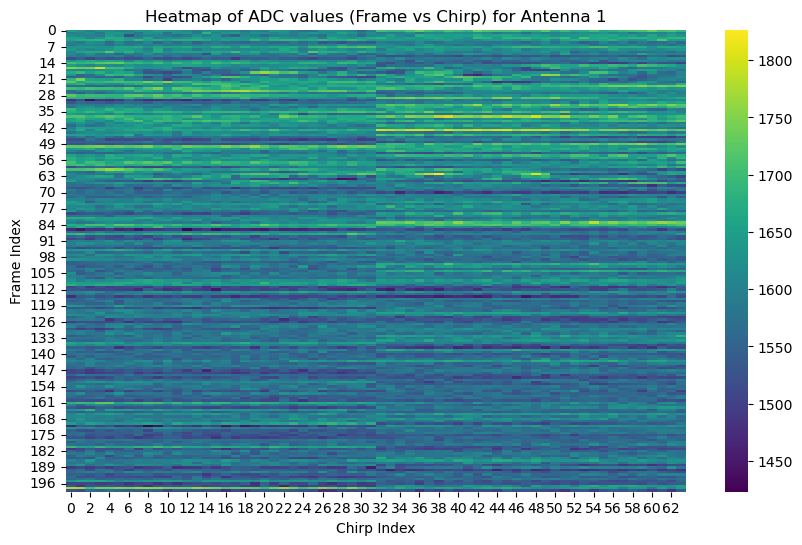

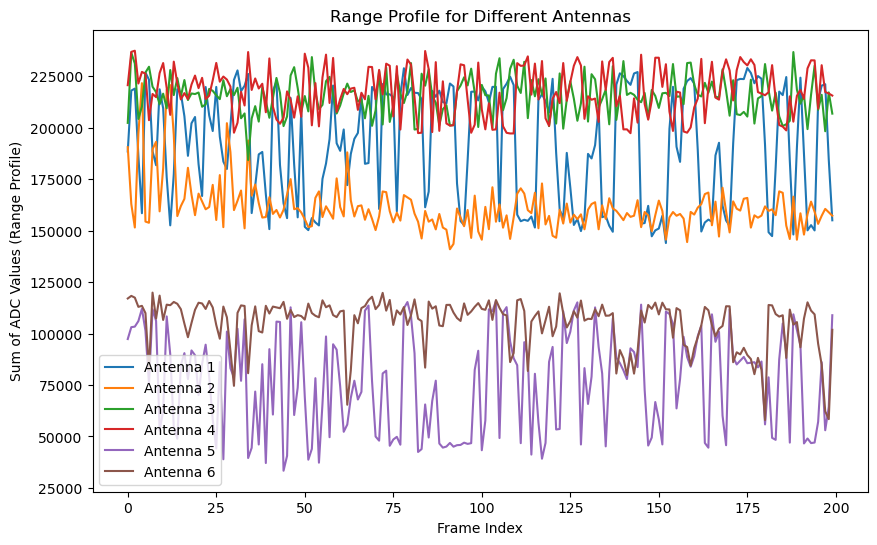

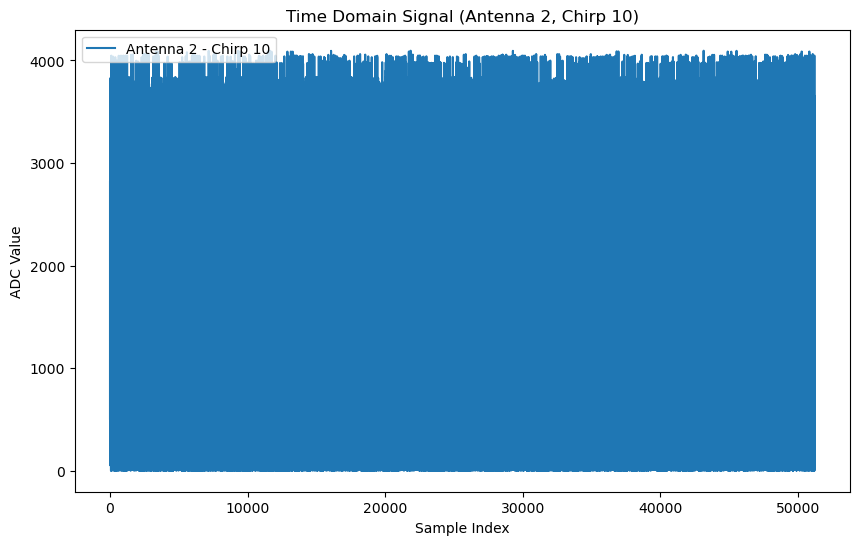

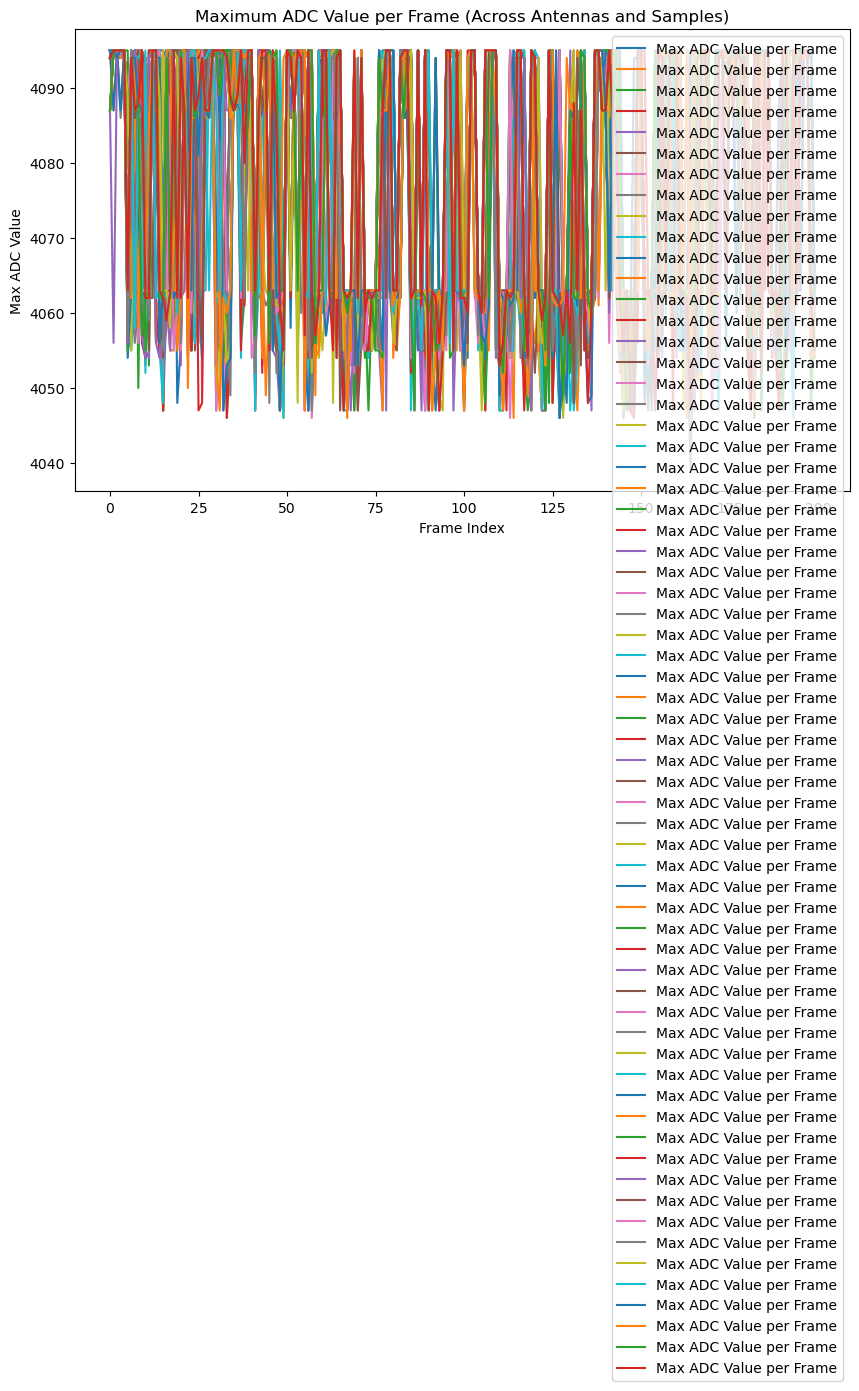

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Load the CSV file into a DataFrame
csv_file_path = r'C:\Users\thoma\Desktop\Masters Project\Raw Data\Raw Data Collection\Subject 1 - Run 1 - Sitting - 4 Minutes\binOutput.csv'  # Path to your CSV file
df = pd.read_csv(csv_file_path)



#Reshape the data into a 4D array for visualization
num_frames = df['Frame Index'].nunique()
num_chirps = df['Chirp Index'].nunique()
num_samples = df['Sample Index'].nunique()
num_antennas = df['Antenna Index'].nunique()

#Create a 4D numpy array
data = np.zeros((num_frames, num_chirps, num_samples, num_antennas), dtype=np.int16)

#Fill the 4D data array using the DataFrame
for row in df.itertuples():
    frame_idx = row[1]
    chirp_idx = row[2]
    sample_idx = row[3]
    antenna_idx = row[4]
    adc_value = row[5]
    
    data[frame_idx, chirp_idx, sample_idx, antenna_idx] = adc_value

#Heatmap of ADC values over frames and chirps 
avg_adc_per_frame_chirp = np.mean(data, axis=2) 

plt.figure(figsize=(10, 6))
sns.heatmap(avg_adc_per_frame_chirp[:, :, 1], cmap='viridis', annot=False)
plt.title("Heatmap of ADC values (Frame vs Chirp) for Antenna 1")
plt.xlabel("Chirp Index")
plt.ylabel("Frame Index")
plt.show()

#Range Profile
range_profile = np.sum(data, axis=1)  # Sum over chirps (axis 1)

plt.figure(figsize=(10, 6))
for antenna_idx in range(num_antennas):
    plt.plot(range_profile[:, 0, antenna_idx], label=f"Antenna {antenna_idx+1}")

plt.title("Range Profile for Different Antennas")
plt.xlabel("Frame Index")
plt.ylabel("Sum of ADC Values (Range Profile)")
plt.legend()
plt.show()

#Time Domain Signal

#antenna and chirp ids
antenna_idx = 1 
chirp_idx = 10 

plt.figure(figsize=(10, 6))
plt.plot(data[:, chirp_idx, :, antenna_idx].flatten(), label=f"Antenna {antenna_idx+1} - Chirp {chirp_idx}")
plt.title(f"Time Domain Signal (Antenna {antenna_idx+1}, Chirp {chirp_idx})")
plt.xlabel("Sample Index")
plt.ylabel("ADC Value")
plt.legend()
plt.show()

#Maximum ADC Value per Frame
max_adc_per_frame = np.max(data, axis=(2, 3))

plt.figure(figsize=(10, 6))
plt.plot(max_adc_per_frame, label="Max ADC Value per Frame")
plt.title("Maximum ADC Value per Frame (Across Antennas and Samples)")
plt.xlabel("Frame Index")
plt.ylabel("Max ADC Value")
plt.legend()
plt.show()



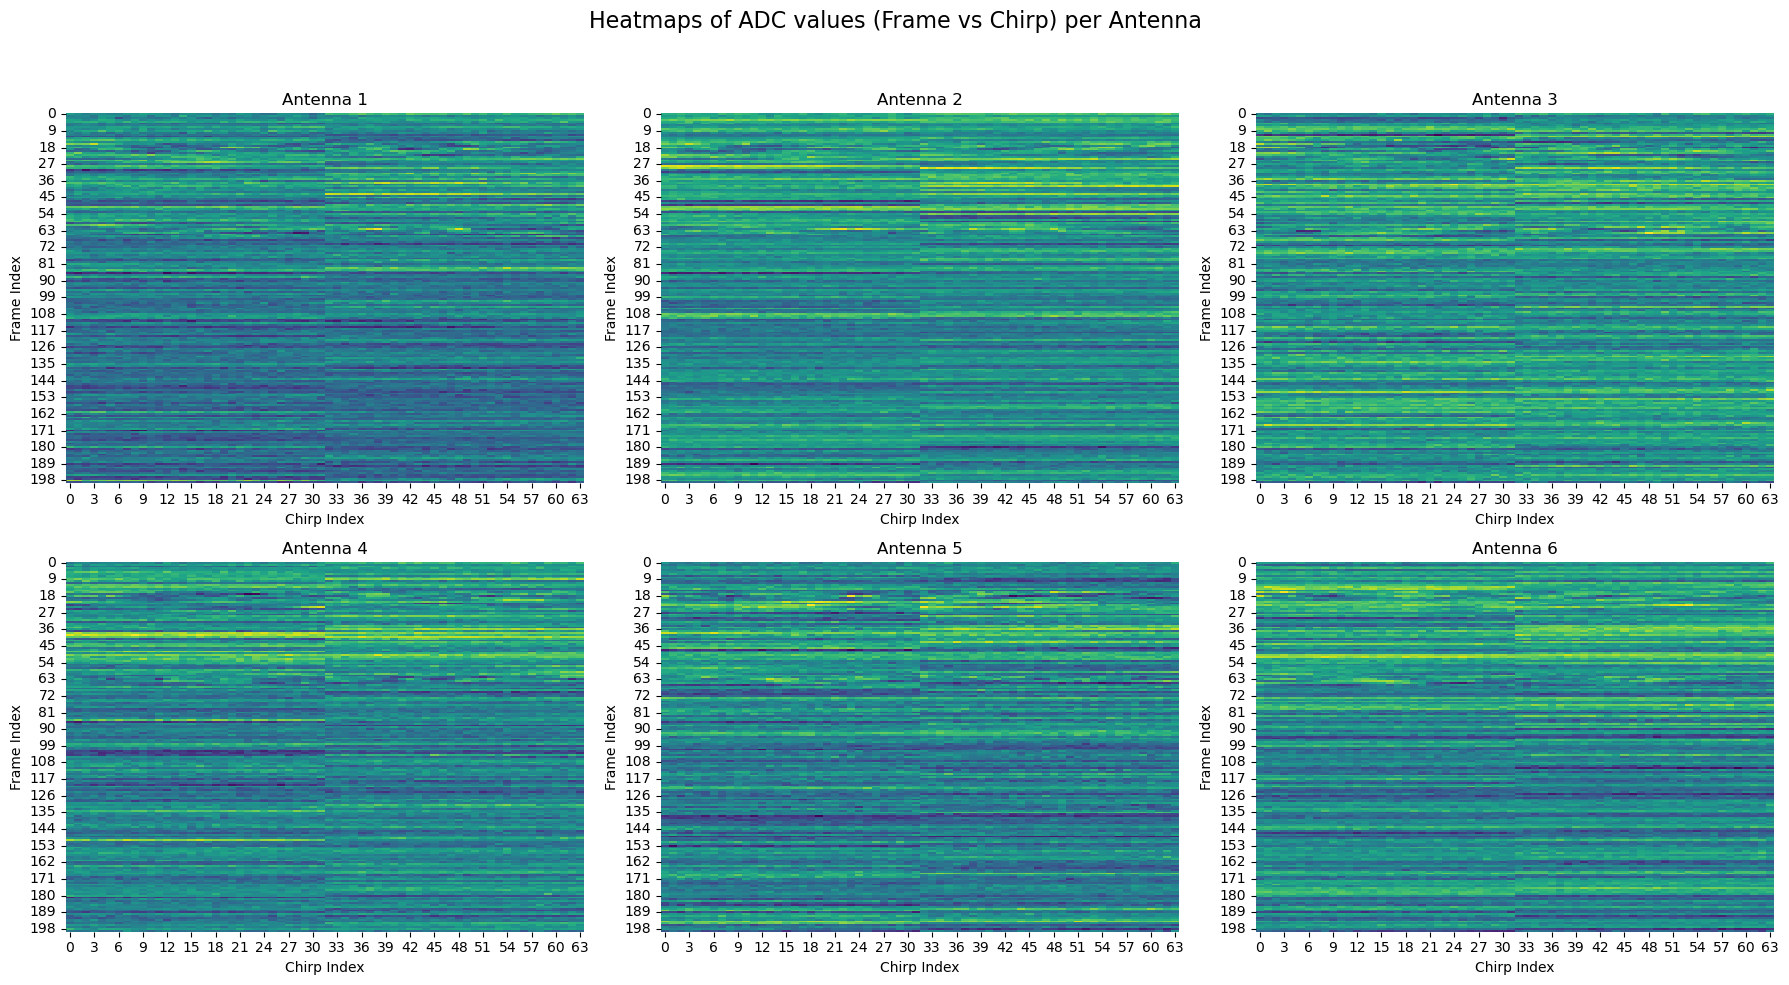

In [8]:


num_antennas = avg_adc_per_frame_chirp.shape[2]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for antenna_idx in range(num_antennas):
    ax = axes[antenna_idx]
    sns.heatmap(avg_adc_per_frame_chirp[:, :, antenna_idx],
                cmap='viridis',
                annot=False,
                ax=ax,
                cbar=False)
    ax.set_title(f"Antenna {antenna_idx + 1}")
    ax.set_xlabel("Chirp Index")
    ax.set_ylabel("Frame Index")

plt.suptitle("Heatmaps of ADC values (Frame vs Chirp) per Antenna", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


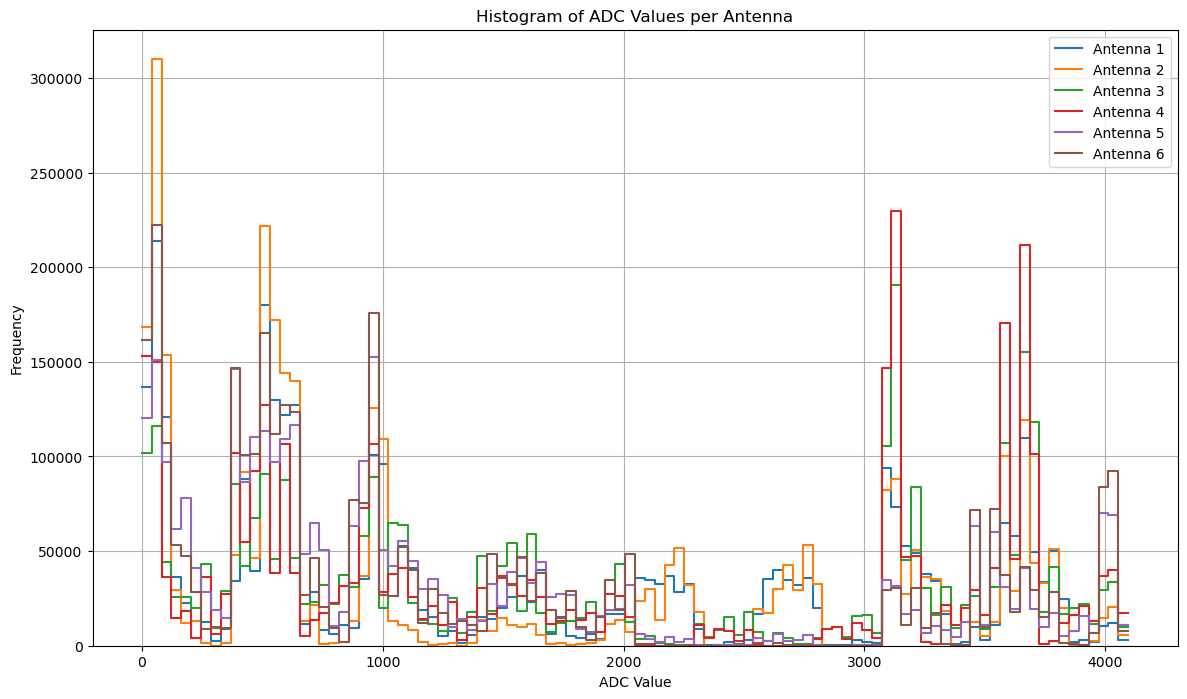

In [9]:
adc_values_per_antenna = [data[:, :, :, i].flatten() for i in range(num_antennas)]
plt.figure(figsize=(14, 8))

for i in range(num_antennas):
    sns.histplot(adc_values_per_antenna[i], bins=100, kde=False, label=f'Antenna {i+1}', element='step', fill=False)

plt.title('Histogram of ADC Values per Antenna')
plt.xlabel('ADC Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

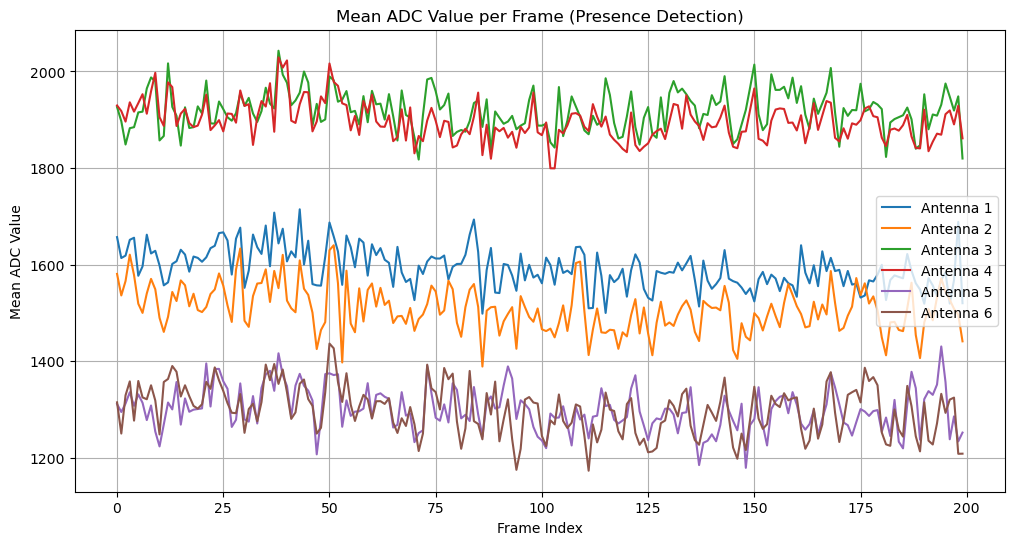

In [10]:
mean_adc_per_frame = np.mean(data, axis=(1, 2))

plt.figure(figsize=(12, 6))
for i in range(num_antennas):
    plt.plot(mean_adc_per_frame[:, i], label=f'Antenna {i+1}')
plt.title('Mean ADC Value per Frame')
plt.xlabel('Frame Index')
plt.ylabel('Mean ADC Value')
plt.legend()
plt.grid(True)
plt.show()


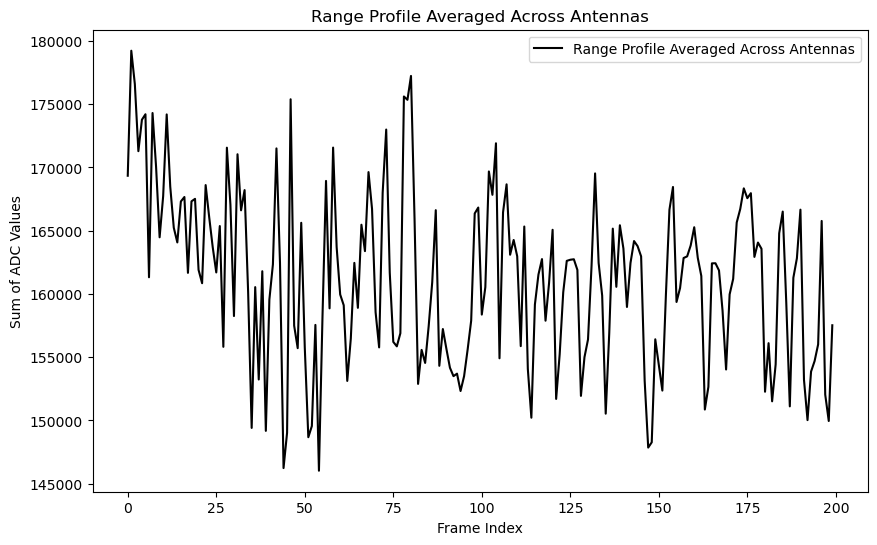

In [11]:
avg_data_across_antennas = np.mean(data, axis=3)
range_profile_avg = np.sum(avg_data_across_antennas, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(range_profile_avg[:, 0], label="Range Profile Averaged Across Antennas", color='black')
plt.title("Range Profile Averaged Across Antennas")
plt.xlabel("Frame Index")
plt.ylabel("Sum of ADC Values")
plt.legend()
plt.show()

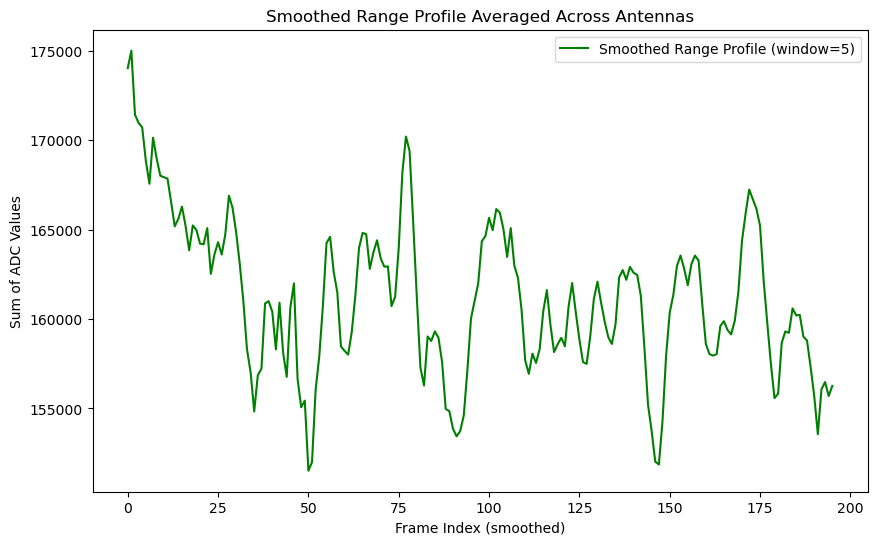

In [12]:
window_size = 5
smoothed_avg_data = np.convolve(range_profile_avg[:, 0], np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 6))
plt.plot(smoothed_avg_data, label=f"Smoothed Range Profile (window={window_size})", color='green')
plt.title("Smoothed Range Profile Averaged Across Antennas")
plt.xlabel("Frame Index (smoothed)")
plt.ylabel("Sum of ADC Values")
plt.legend()
plt.show()

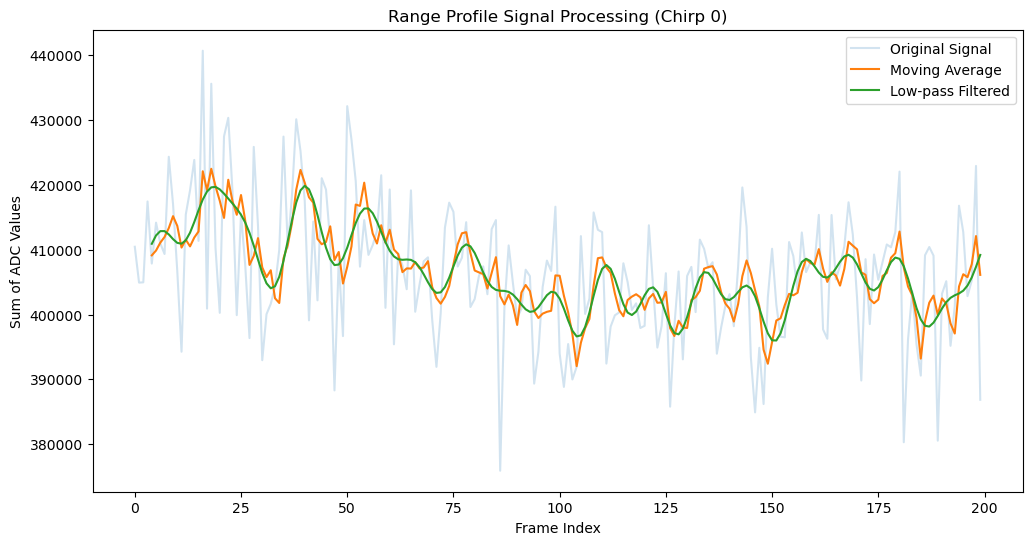

In [17]:
from scipy.fft import fft, ifft

# Moving average filter function
def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Low-pass filter in frequency domain
def low_pass_filter(data, cutoff_freq, sampling_rate):
    fft_data = fft(data)
    freqs = np.fft.fftfreq(len(data), 1/sampling_rate)
    fft_data[np.abs(freqs) > cutoff_freq] = 0
    filtered = np.real(ifft(fft_data))
    return filtered


# Average over antennas and samples to get range profile per frame
avg_over_antennas = np.mean(data, axis=3) 
range_profile = np.sum(avg_over_antennas, axis=2)  
chirp_to_use = 0
signal = range_profile[:, chirp_to_use]

# Parameters for filtering
window_size = 5
cutoff_frequency = 0.1  
sampling_rate = 1.0    

# Apply moving average smoothing
smoothed_signal = moving_average(signal, window_size)

# Apply low-pass filter to the smoothed signal
filtered_signal = low_pass_filter(smoothed_signal, cutoff_frequency, sampling_rate)

plt.figure(figsize=(12, 6))
plt.plot(signal, label='Original Signal', alpha=0.2)
plt.plot(np.arange(window_size-1, window_size-1+len(smoothed_signal)), smoothed_signal, label='Moving Average')
plt.plot(np.arange(window_size-1, window_size-1+len(filtered_signal)), filtered_signal, label='Low-pass Filtered')
plt.title(f'Range Profile Signal Processing (Chirp {chirp_to_use})')
plt.xlabel('Frame Index')
plt.ylabel('Sum of ADC Values')
plt.legend()
plt.show()

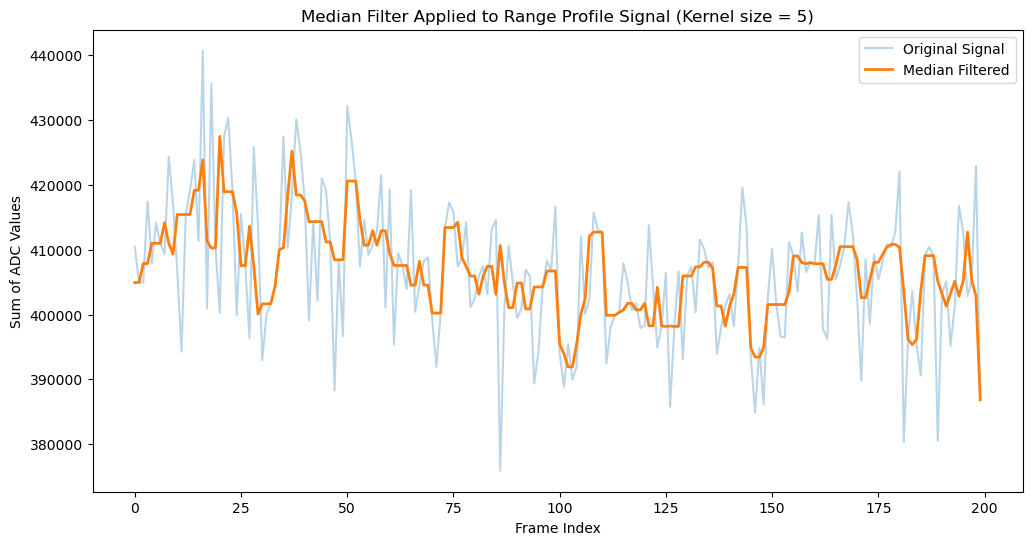

In [16]:
from scipy.signal import medfilt

# Apply median filter to reduce spikes
kernel_size = 5  

signal_median_filtered = medfilt(signal, kernel_size=kernel_size)

plt.figure(figsize=(12, 6))
plt.plot(signal, label='Original Signal', alpha=0.3)
plt.plot(signal_median_filtered, label='Median Filtered', linewidth=2)
plt.title(f'Median Filter Applied to Range Profile Signal (Kernel size = {kernel_size})')
plt.xlabel('Frame Index')
plt.ylabel('Sum of ADC Values')
plt.legend()
plt.show()



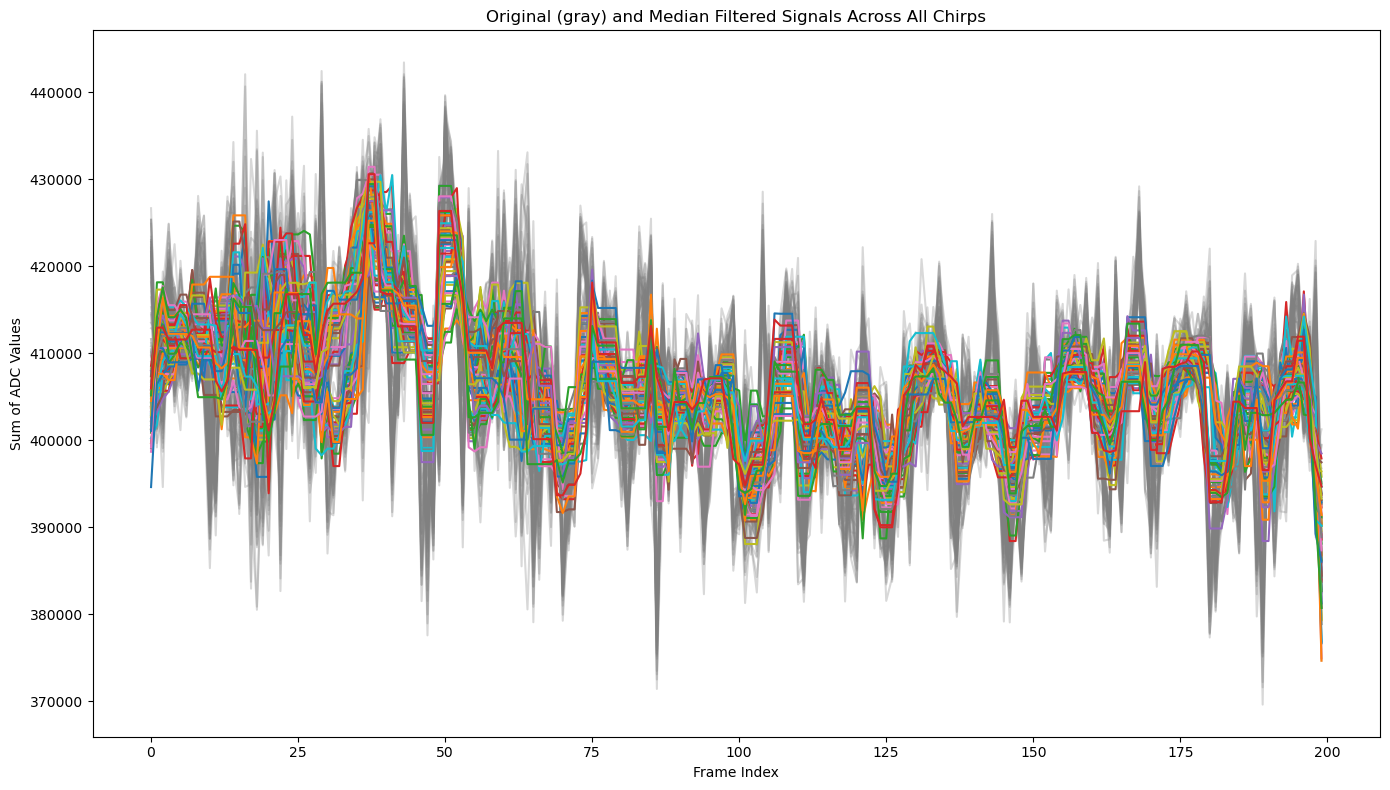

In [22]:
# Apply median filter across frames for each chirp
filtered_range_profile = np.zeros_like(range_profile)
for chirp_idx in range(range_profile.shape[1]):
    filtered_range_profile[:, chirp_idx] = medfilt(range_profile[:, chirp_idx], kernel_size=kernel_size)

plt.figure(figsize=(14, 8))

# Plot original signals for all chirps (with transparency)
for chirp_idx in range(range_profile.shape[1]):
    plt.plot(range_profile[:, chirp_idx], color='gray', alpha=0.3)

# Plot median filtered signals for all chirps (thicker lines)
for chirp_idx in range(filtered_range_profile.shape[1]):
    plt.plot(filtered_range_profile[:, chirp_idx], label=f'Chirp {chirp_idx}', linewidth=1.5)

plt.title('Original (gray) and Median Filtered Signals Across All Chirps')
plt.xlabel('Frame Index')
plt.ylabel('Sum of ADC Values')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

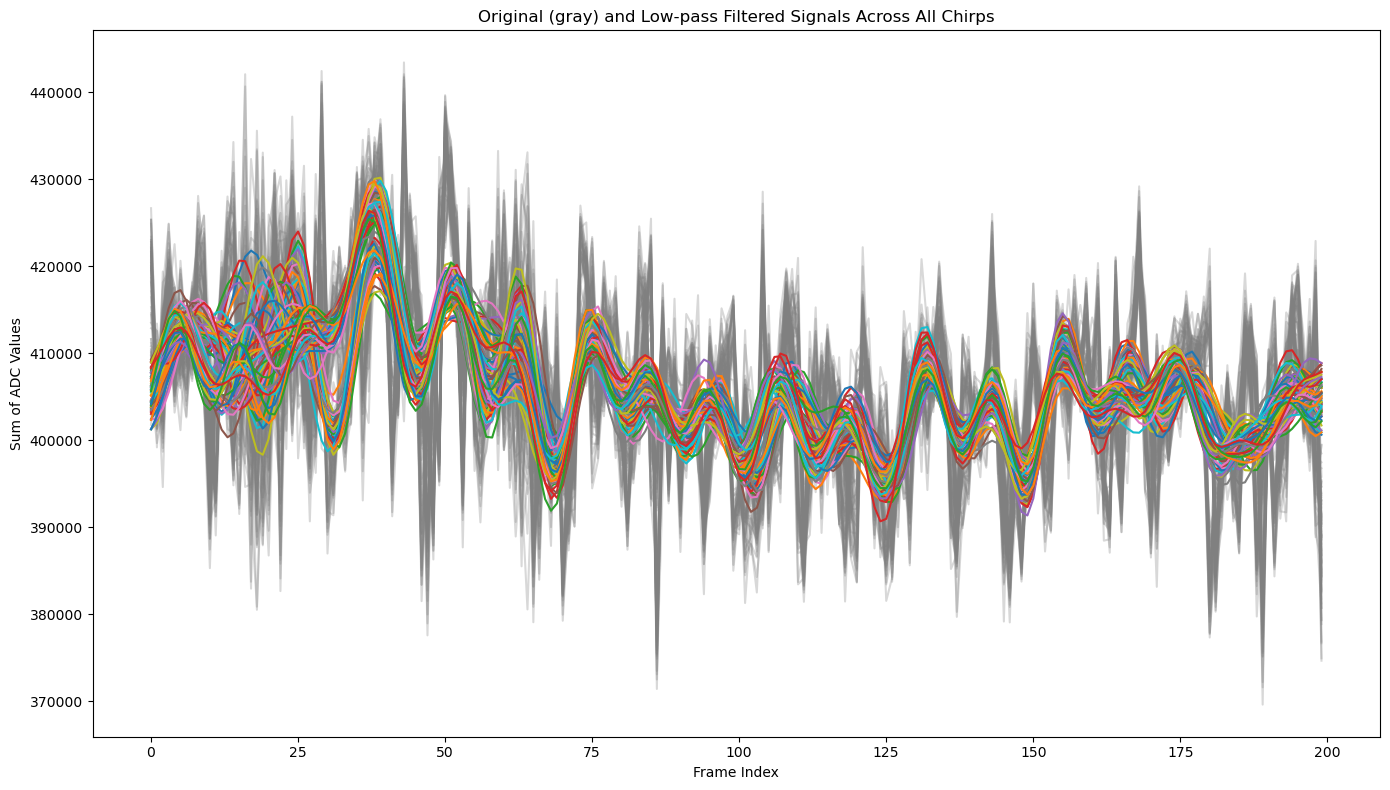

In [21]:
filtered_range_profile = np.zeros_like(range_profile)
for chirp_idx in range(range_profile.shape[1]):
    filtered_range_profile[:, chirp_idx] = low_pass_filter(range_profile[:, chirp_idx], cutoff_frequency, sampling_rate)

plt.figure(figsize=(14, 8))

# Plot original signals for all chirps (gray transparent)
for chirp_idx in range(range_profile.shape[1]):
    plt.plot(range_profile[:, chirp_idx], color='gray', alpha=0.3)

# Plot low-pass filtered signals for all chirps (bold)
for chirp_idx in range(filtered_range_profile.shape[1]):
    plt.plot(filtered_range_profile[:, chirp_idx], label=f'Chirp {chirp_idx}', linewidth=1.5)

plt.title('Original (gray) and Low-pass Filtered Signals Across All Chirps')
plt.xlabel('Frame Index')
plt.ylabel('Sum of ADC Values')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()